In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

# Directory - using absolute path from notebook directory
tfrecord_dir = '../data/raw/ndws_western_dataset'

# Load one TFRecord for inspection
tfrecord_file = os.path.join(tfrecord_dir, "cleaned_eval_ndws_conus_western_000.tfrecord")

raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

stats = {}

for raw_record in raw_dataset.take(1):  # just one sample
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    feature_dict = example.features.feature

    for key, value in feature_dict.items():
        vals = np.array(value.float_list.value)
        stats[key] = {
            "mean": np.mean(vals),
            "std": np.std(vals),
            "min": np.min(vals),
            "max": np.max(vals)
        }

df_stats = pd.DataFrame(stats).T
print(df_stats.round(4))

                         mean        std        min        max
wdir_wind             -2.1266     0.8096    -3.3836     2.2453
fuel1                  0.0282     0.5207    -1.2486     2.0892
bi                    42.3576     2.2185    38.2672    50.2753
viirs_FireMask         0.0022     0.0468     0.0000     1.0000
tmp_75                25.0664     1.6878    21.0085    29.3019
elevation           1518.7988   276.5665   804.0000  2344.0000
erc                   55.7233     3.0838    47.0283    61.3013
chili                180.8064    47.5647     0.0000   254.0000
viirs_PrevFireMask     0.0051     0.0714     0.0000     1.0000
tmp_day               24.8555     1.6998    20.8292    29.0572
NDVI                6516.4558  1071.8338  2289.0000  8443.0000
pdsi                  -1.0271     0.5784    -1.6212     0.8493
wind_avg               3.6229     0.6247     2.0656     4.8289
fuel2                  0.5426     0.7506    -1.7386     4.2761
fuel3                 -0.1834     1.3308    -3.9051    

In [4]:
import math
import numpy as np
import tensorflow as tf
import pandas as pd
import os

tfrecord_dir = '../data/raw/ndws_western_dataset'
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(tfrecord_dir) if f.endswith(".tfrecord")]

feature_sums = {}
feature_sqsums = {}
corr_sums = {}
corr_counts = {}
total_count = 0
max_records = 800   # limit to speed up

record_counter = 0
for file in tfrecord_files:
    dataset = tf.data.TFRecordDataset(file)
    for raw_record in dataset.take(max_records):
        record_counter += 1
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        feat = {k: np.array(v.float_list.value) for k, v in example.features.feature.items()}

        grid = int(math.sqrt(len(feat["viirs_FireMask"])))
        mask = (feat["viirs_FireMask"].reshape(grid, grid) > 0).astype(int).flatten()

        for k, arr in feat.items():
            arr_flat = arr.flatten()

            # skip all-NaN or constant arrays
            if np.all(arr_flat == arr_flat[0]):
                continue

            if k not in feature_sums:
                feature_sums[k] = 0
                feature_sqsums[k] = 0
                corr_sums[k] = 0
                corr_counts[k] = 0

            feature_sums[k] += arr_flat.sum()
            feature_sqsums[k] += (arr_flat**2).sum()
            total_count += len(arr_flat)

            # correlation (ignore NaN)
            try:
                corr = np.corrcoef(arr_flat, mask)[0, 1]
                if not np.isnan(corr):
                    corr_sums[k] += corr
                    corr_counts[k] += 1
            except Exception:
                pass

    if record_counter >= max_records:
        break

# summarize
summary = {}
for k in feature_sums.keys():
    mean = feature_sums[k] / total_count
    std = np.sqrt(feature_sqsums[k]/total_count - mean**2)
    corr_mean = corr_sums[k]/corr_counts[k] if corr_counts[k] else np.nan
    summary[k] = {'mean': mean, 'std': std, 'corr_mean': corr_mean}

df_summary = pd.DataFrame(summary).T.sort_values('corr_mean', ascending=False)
print(df_summary.round(3))

                       mean       std  corr_mean
viirs_FireMask        0.001     0.033      1.000
viirs_PrevFireMask    0.002     0.040      0.321
NDVI                213.341  1060.027      0.043
bi                    2.505    12.196      0.024
wind_avg              0.139     0.710      0.022
erc                   3.143    15.306      0.022
fuel2                 0.019     0.220      0.020
pr                    0.002     0.082      0.018
elevation            65.014   345.147      0.016
wind_75               0.186     0.955      0.015
fuel1                 0.003     0.155      0.009
gust_med              0.247     1.326      0.002
wdir_gust             0.022     0.384     -0.003
water                 0.081     2.249     -0.006
chili                 8.249    39.025     -0.007
wdir_wind             0.022     0.381     -0.007
avg_sph               0.000     0.001     -0.009
fuel3                 0.018     0.300     -0.009
pdsi                 -0.047     0.436     -0.017
impervious          

In [5]:
# Define parse_tfrecord function
def parse_tfrecord(raw_record):
    """Parse a single TFRecord example into features (X) and target (y)"""
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    feat = {k: np.array(v.float_list.value) for k, v in example.features.feature.items()}
    
    # Determine grid size (assuming square grid)
    grid = int(math.sqrt(len(feat["viirs_FireMask"])))
    
    # Extract target (fire mask)
    y = feat["viirs_FireMask"].reshape(grid, grid)
    
    # Extract features (all except fire mask)
    feature_names = [k for k in feat.keys() if k != "viirs_FireMask"]
    X = np.stack([feat[k].reshape(grid, grid) for k in feature_names], axis=-1)
    
    return X, y

# Now use the function
raw_dataset = tf.data.TFRecordDataset(tfrecord_files[0])
X_list, y_list = [], []

for raw_record in raw_dataset.take(100):  # reduced from 1000 to speed up
    X, y = parse_tfrecord(raw_record)
    X_list.append(X)
    y_list.append(y)

X_array = np.array(X_list)
y_array = np.array(y_list)

print("X shape:", X_array.shape)  # (num_samples, 64, 64, num_features)
print("y shape:", y_array.shape)  # (num_samples, 64, 64)

X shape: (100, 64, 64, 22)
y shape: (100, 64, 64)


Features present in this record:

- wdir_wind (length: 4096)
- fuel1 (length: 4096)
- bi (length: 4096)
- viirs_FireMask (length: 4096)
- tmp_75 (length: 4096)
- elevation (length: 4096)
- erc (length: 4096)
- chili (length: 4096)
- viirs_PrevFireMask (length: 4096)
- tmp_day (length: 4096)
- NDVI (length: 4096)
- pdsi (length: 4096)
- wind_avg (length: 4096)
- fuel2 (length: 4096)
- fuel3 (length: 4096)
- impervious (length: 4096)
- population (length: 4096)
- gust_med (length: 4096)
- pr (length: 4096)
- avg_sph (length: 4096)
- wdir_gust (length: 4096)
- wind_75 (length: 4096)
- water (length: 4096)


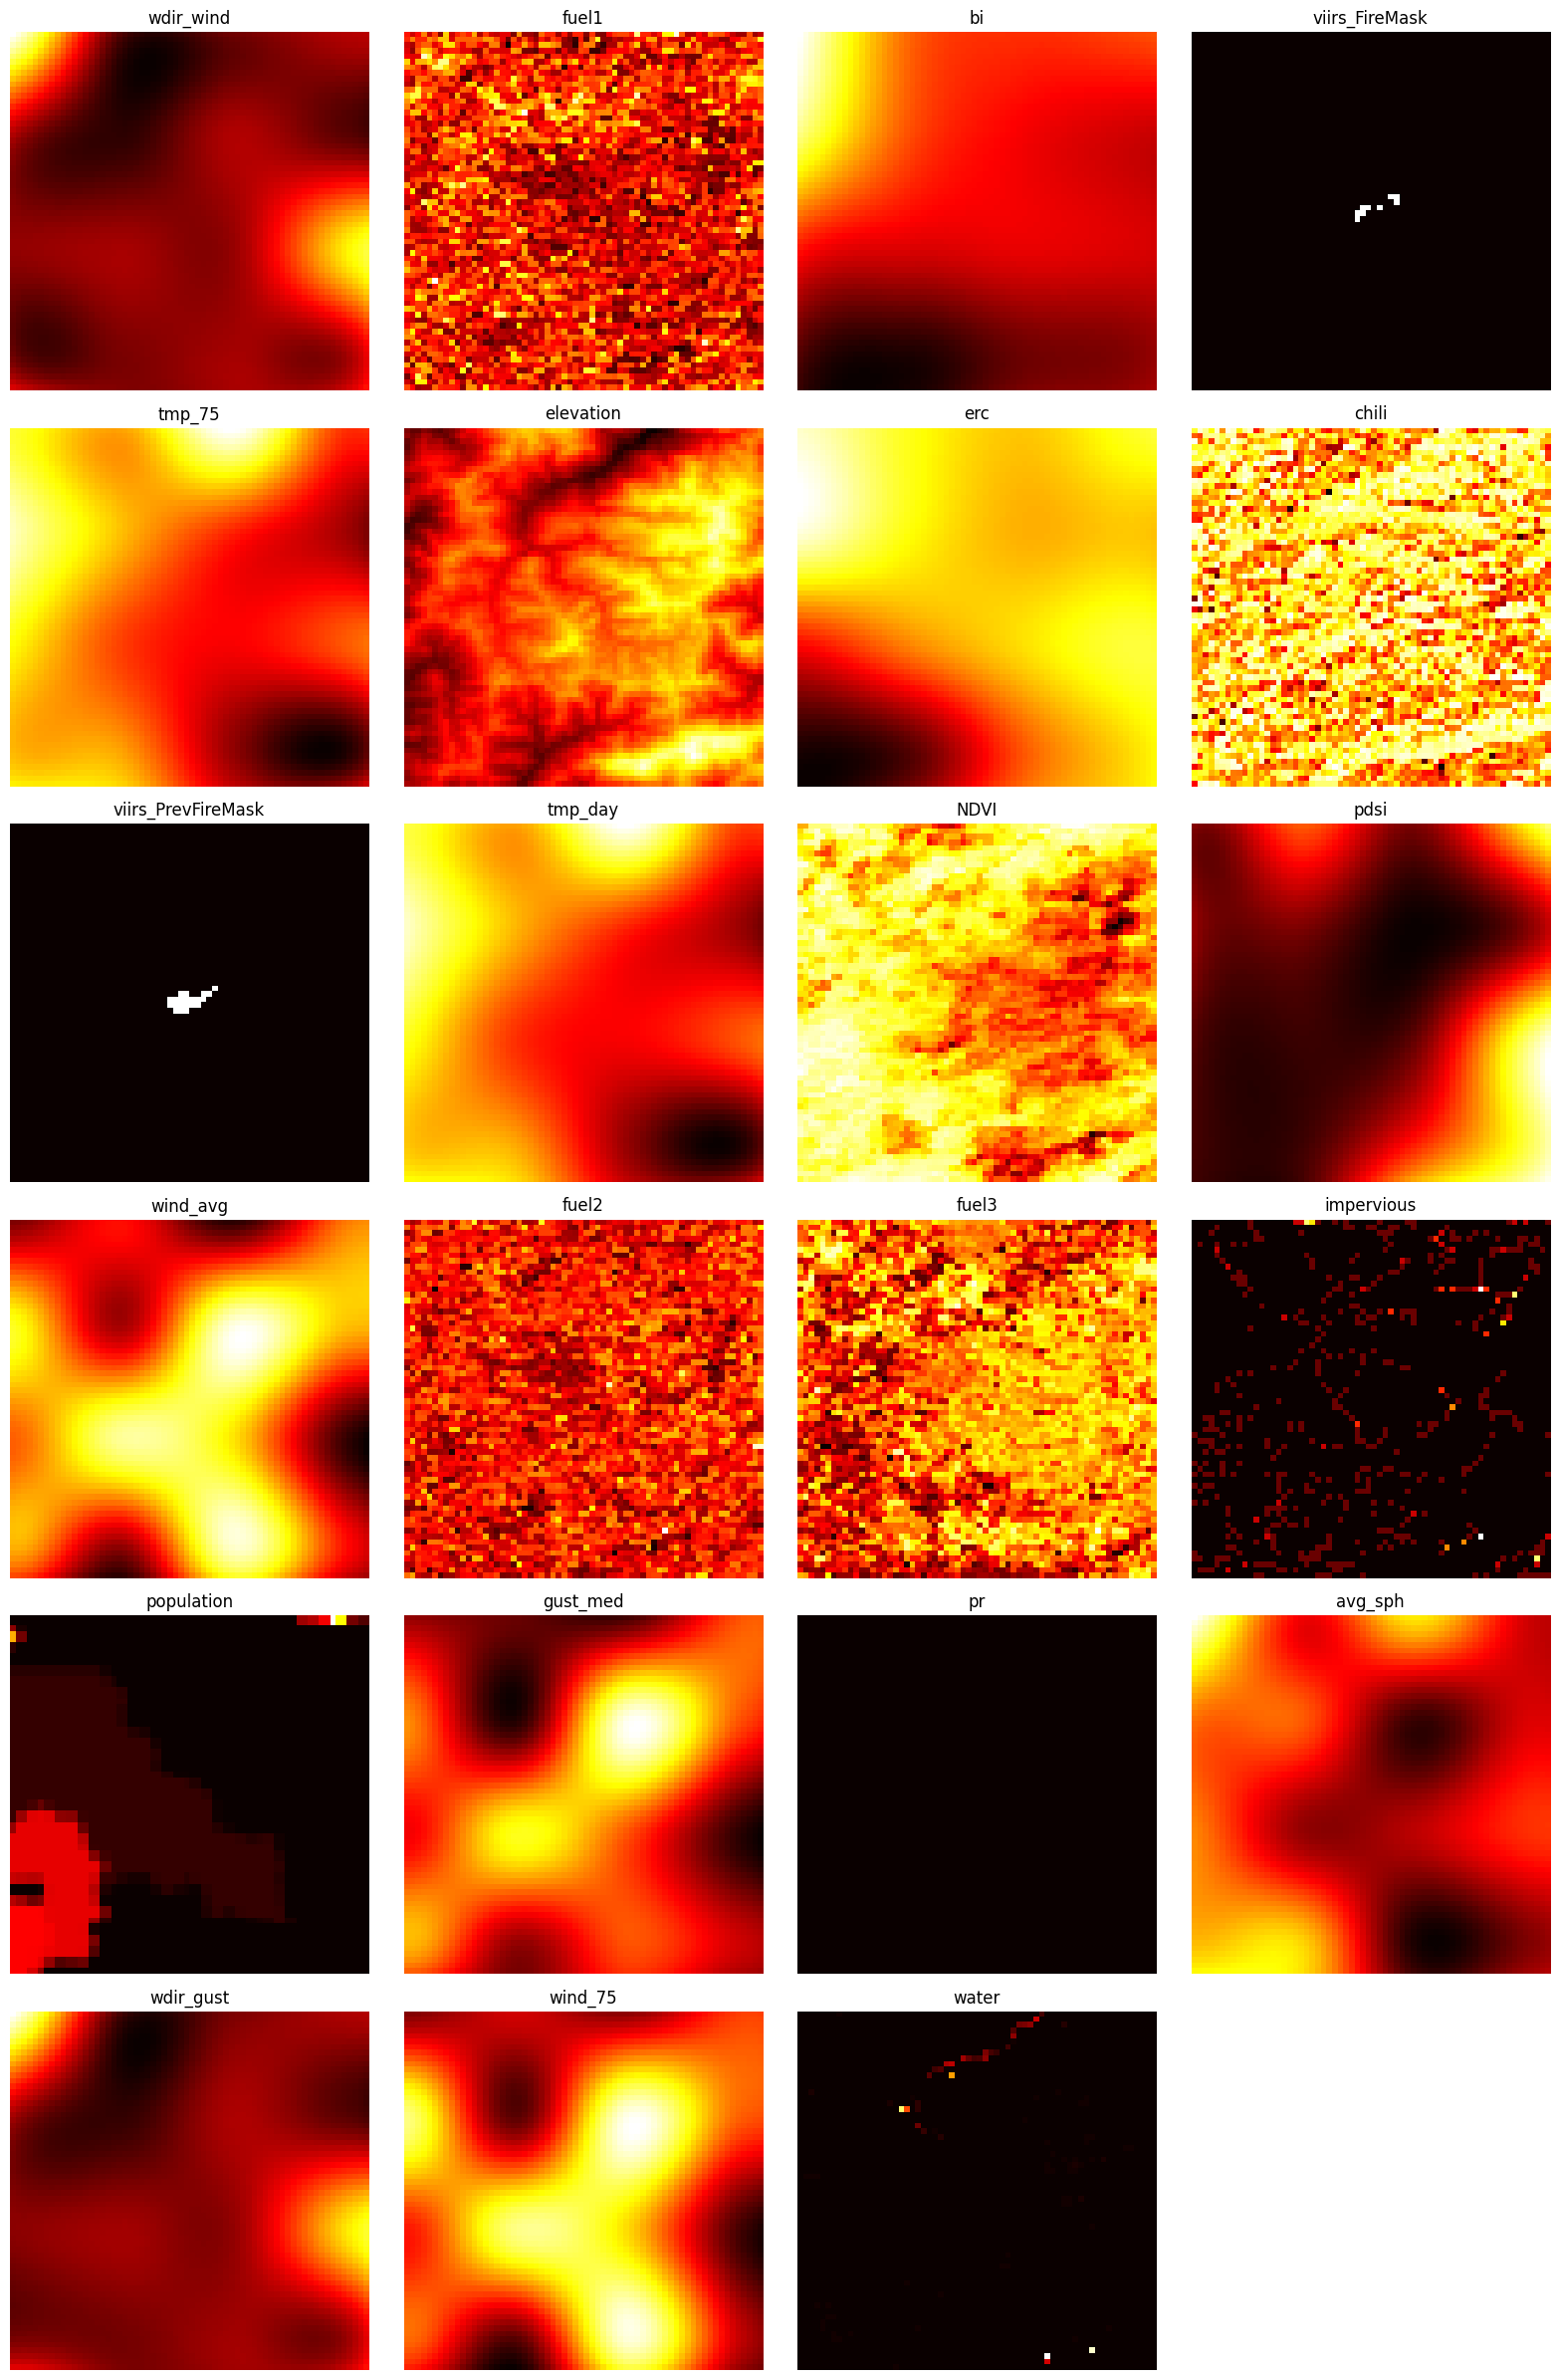

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Pick a single TFRecord file (for example, the first eval file)
tfrecord_file = os.path.join(tfrecord_dir, "cleaned_eval_ndws_conus_western_000.tfrecord")

# Create a TF dataset
raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

# Parse a single record
raw_record = next(iter(raw_dataset))
example = tf.train.Example()
example.ParseFromString(raw_record.numpy())

# Extract features
feature_dict = {k: np.array(v.float_list.value) for k, v in example.features.feature.items()}

# All feature names
feature_names = list(feature_dict.keys())
print("Features present in this record:\n")
for f in feature_names:
    print(f"- {f} (length: {len(feature_dict[f])})")

# -----------------------------
# Visualize each feature as heatmap
# -----------------------------
IMG_SIZE = int(np.sqrt(len(feature_dict[feature_names[0]])))  # Assuming square 2D features
num_features = len(feature_names)

cols = 4  # Number of columns in plot grid
rows = int(np.ceil(num_features / cols))

plt.figure(figsize=(16, 4*rows))

for i, f in enumerate(feature_names):
    arr = feature_dict[f].reshape(IMG_SIZE, IMG_SIZE)
    plt.subplot(rows, cols, i+1)
    plt.imshow(arr, cmap='hot')
    plt.title(f)
    plt.axis('off')

plt.tight_layout()
plt.show()

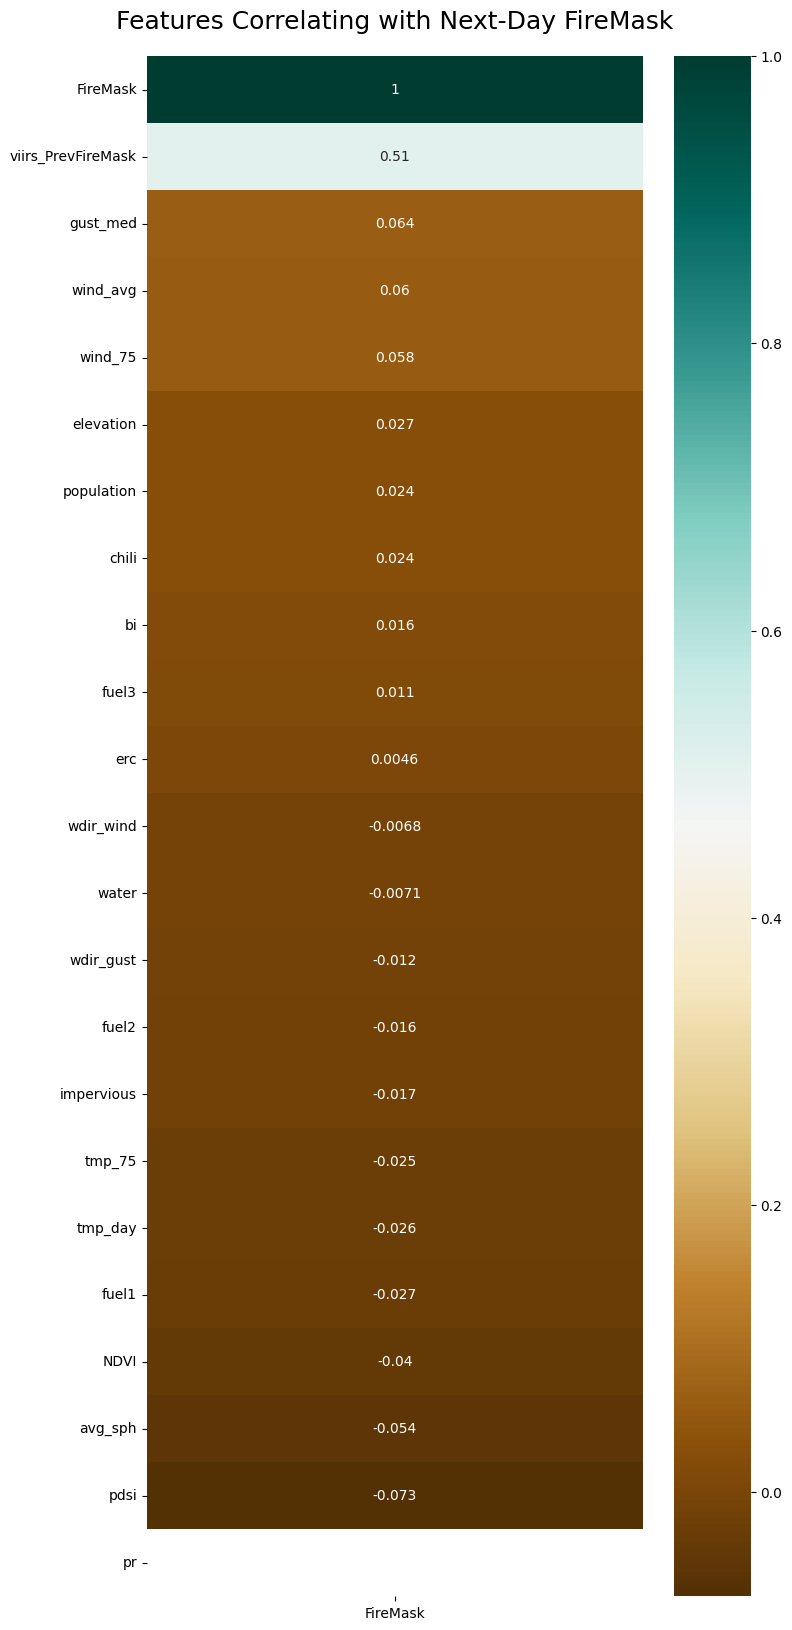

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten all features into a DataFrame
X_flat = np.stack([v for k, v in feature_dict.items() if k != 'viirs_FireMask'], axis=-1)
y_flat = feature_dict['viirs_FireMask']

feature_names = [k for k in feature_dict.keys() if k != 'viirs_FireMask']

# Create DataFrame
df = pd.DataFrame(X_flat, columns=feature_names)
df['FireMask'] = y_flat

# Compute Spearman correlation with target
corr = df.corr(method='spearman')['FireMask'].sort_values(ascending=False)

# Plot heatmap
plt.figure(figsize=(8, 20))
ax = sns.heatmap(corr.to_frame(), annot=True, cmap='BrBG', cbar=True)
ax.set_title('Features Correlating with Next-Day FireMask', fontdict={'fontsize':18}, pad=20)
plt.show()


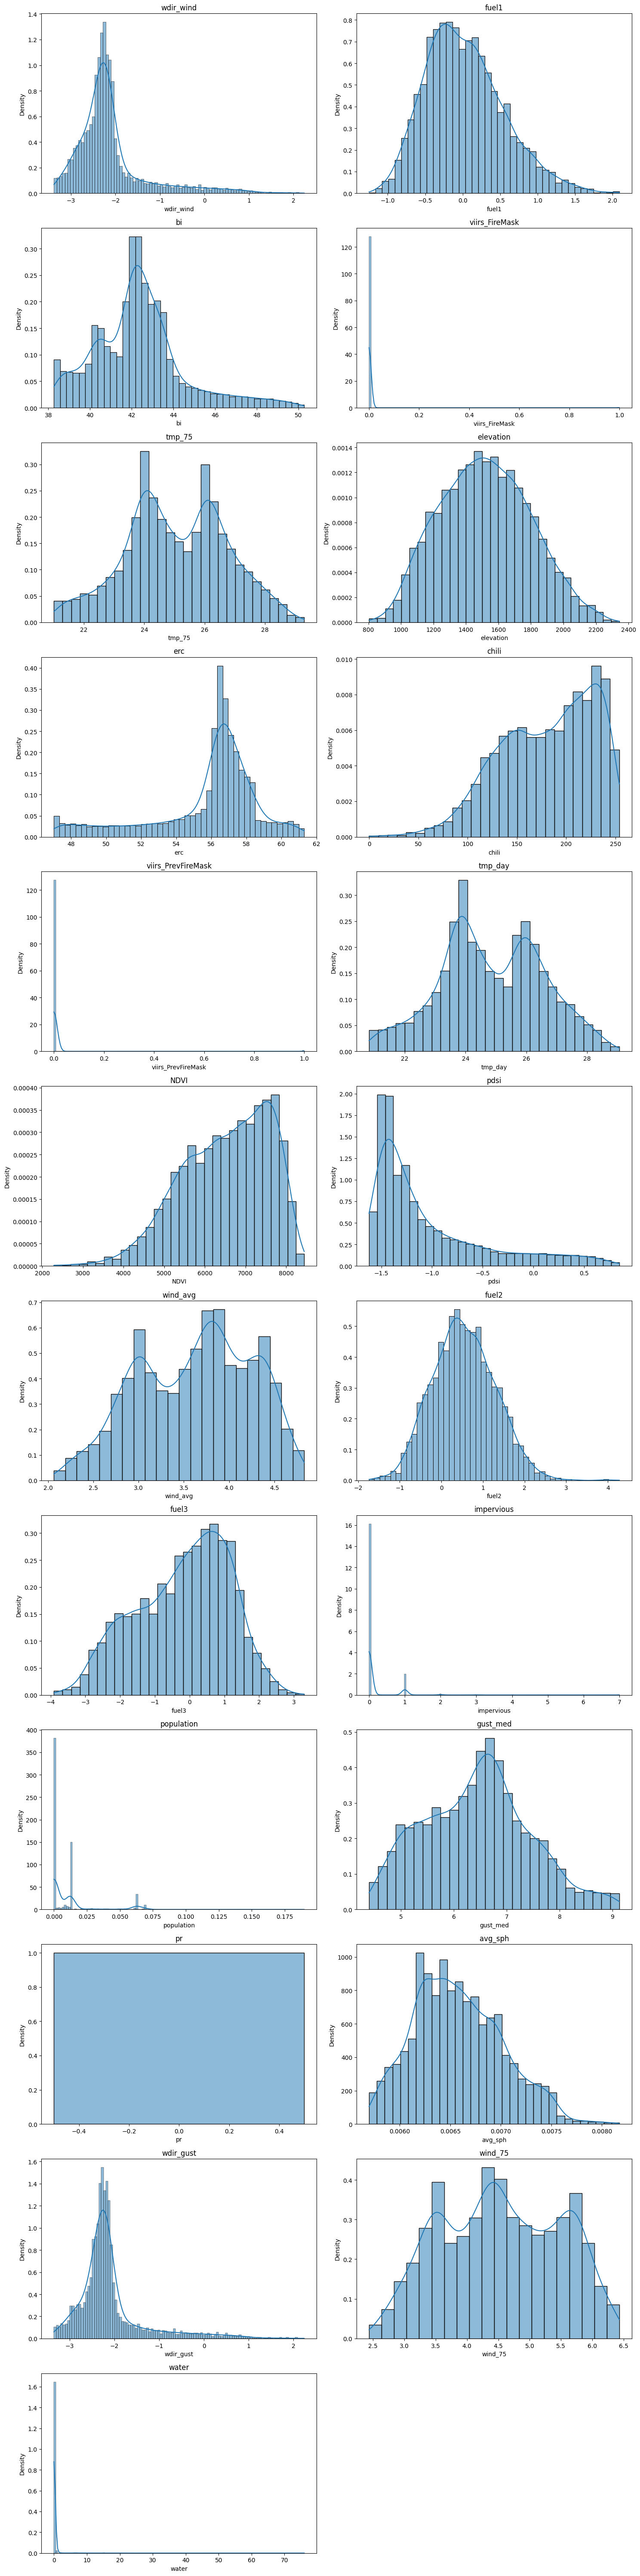

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Flatten all features into a DataFrame
X_flat = np.stack([v for k, v in feature_dict.items()], axis=-1)
feature_names = list(feature_dict.keys())

df = pd.DataFrame(X_flat, columns=feature_names)

# Determine number of columns and rows for plotting
ncols = 2
nrows = int(np.ceil(len(feature_names) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows))
axes = axes.ravel()

# Plot distribution for each feature
for i, col in enumerate(feature_names):
    sns.histplot(df[col], kde=True, stat='density', ax=axes[i])
    axes[i].set_title(col)

# Remove unused axes if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
